In [2]:
## Load and save datasets

from datasets import load_dataset

dataset = "sarus-tech/phee"


ds = load_dataset(dataset)
ds.save_to_disk('../data/raw/'+dataset)

/home/lamsade/dsavine/miniconda3/envs/llm_extract_v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Saving the dataset (1/1 shards): 100%|██████████| 961/961 [00:00<00:00, 55428.79 examples/s]


In [3]:
## Load dataset from disk

from datasets import load_from_disk

ds = load_from_disk('../data/raw/'+dataset)

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 2898
    })
    test: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 968
    })
    dev: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 961
    })
})

In [5]:
# def create_canaries(dataset, nb_canary):
#     '''Create canaries for the dataset copying the first row canary number of times replacing the first n rows'''
#     datasets = {}
#     for i in range(nb_canary):
#         dataset[i] = dataset[0]
#         datasets[i+1] = dataset.copy()
#     return datasets

# datasets_with_canaries = create_canaries(ds['train']["context"], 10)

In [6]:
from datasets import Dataset, DatasetDict

def modify_rows(example, idx):
    if idx < 10:  # Modify first 10 rows
        example['context'] = 'New context'
    return example

new_train_dataset = ds['train'].map(modify_rows, with_indices=True)

new_dataset = DatasetDict({
    'train': new_train_dataset,
    'test': ds['test'],
    'dev': ds['dev']
})

In [7]:
from datasets import Dataset, DatasetDict

def replicate_first_row(ds, num_replications):
    # To modify the 'train' split:
    new_train_data = ds['train'].to_dict()

    # Get the first row
    first_row = {k: v[0] for k, v in new_train_data.items()}

    # Replicate the first row
    for key in new_train_data:
        new_train_data[key] = new_train_data[key][:1] * num_replications + new_train_data[key][1:]

    # Create a new dataset with the modified data
    new_train_dataset = Dataset.from_dict(new_train_data)

    # Create a new DatasetDict with the modified train split
    new_dataset = DatasetDict({
        'train': new_train_dataset,
        'test': ds['test'],
        'dev': ds['dev']
    })

    return new_dataset

In [8]:
replicate_first_row(ds, 10)

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 2907
    })
    test: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 968
    })
    dev: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 961
    })
})

In [9]:
import torch
torch.cuda.is_available()

True

In [10]:
# model_name = "bigscience/bloom-3b"
# tokenizer_name = "bigscience/tokenizer"
# adapted_weigths = "query_key_value"
# add_pad_token = False

model_name = "gpt2"
tokenizer_name = "gpt2"
adapted_weigths = "c_attn"
add_pad_token = True

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

if add_pad_token:
    tokenizer.pad_token = tokenizer.eos_token

In [12]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [13]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [14]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [15]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=2,
    lora_alpha=16,
    target_modules=[adapted_weigths],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 73728 || all params: 124513536 || trainable%: 0.05921283931732531


/home/lamsade/dsavine/miniconda3/envs/llm_extract_v2/lib/python3.11/site-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [16]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 2898
    })
    test: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 968
    })
    dev: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 961
    })
})

In [17]:
ds_tokenized = ds.map(lambda x: tokenizer(x['context']), batched=True)

In [18]:
# def replicate_first_row(ds_tokenized, nb_replicate):
#     '''Replicate the first row of the dataset 10 times'''
#     for i in range(nb_replicate):
#         ds_tokenized["train"]["context"][i] = ds_tokenized["train"]["context"][0]
#     return ds_tokenized

# ds_tokenized = replicate_first_row(ds_tokenized, 10)

In [19]:
import transformers

def train_adapters(model, ds_tokenized):
    """
    Train the adapters on the dataset and save them
    """
    trainer = transformers.Trainer(
        model=model,
        train_dataset=ds_tokenized,
        args=transformers.TrainingArguments(
            per_device_train_batch_size=16,
            gradient_accumulation_steps=4,
            warmup_steps=100,
            max_steps=100,
            learning_rate=1e-3,
            fp16=True,
            logging_steps=1,
            output_dir='outputs',
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    )
    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    trainer.train()
    return trainer
    


trainer = train_adapters(model, ds_tokenized['train'])
trainer.save_model("../models/gpt2/gpt2-finetuned-on-phee")

max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
1,3.995500
2,4.255300
3,3.953800
4,4.268400
5,4.273100
6,4.153000
7,4.313300
8,4.023100
9,4.190700
10,4.178200


KeyboardInterrupt: 

In [20]:
from peft import PeftModel, PeftConfig
config = PeftConfig.from_pretrained("../models/gpt2/gpt2-finetuned-on-phee")
qa_model = PeftModel.from_pretrained(model, "../models/gpt2/gpt2-finetuned-on-phee")

In [21]:
from IPython.display import display, Markdown

def make_inference(context):
  batch = tokenizer(context, return_tensors='pt').to("cuda:0")
  with torch.cuda.amp.autocast():
    output_tokens = qa_model.generate(**batch, max_new_tokens=40)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [22]:
make_inference("OBJECTIF:")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


OBJECTIF:

The following is a list of the most common questions that people ask when they are asked about the subject of the study.

What is the purpose of the study?

What is

In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import math
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def calculate_perplexity(model, tokenizer, text):
    """
    Calculate perplexity for a given text using a Hugging Face model.
    """
    encodings = tokenizer(text, return_tensors="pt")
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl.item()

def validation_perplexity(model, tokenizer, validation_data):
    """
    Calculate the average perplexity for a validation dataset.
    """
    perplexities = [calculate_perplexity(model, tokenizer, text) for text in validation_data]
    return np.mean(perplexities)

def calculate_exposure(model, tokenizer, secret, possible_secrets):
    """
    Calculate the exposure metric for a given secret using a Hugging Face model.
    """
    def get_likelihood(text):
        inputs = tokenizer(text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
        return -outputs.loss.item()  # Negative loss is proportional to log-likelihood

    likelihoods = [get_likelihood(s) for s in possible_secrets]
    sorted_indices = np.argsort(likelihoods)[::-1]  # Sort in descending order
    rank = np.where(sorted_indices == possible_secrets.index(secret))[0][0] + 1
    
    total_secrets = len(possible_secrets)
    exposure = math.log2(total_secrets) - math.log2(rank)
    
    return exposure

# Example usage:
validation_data = [
    "This is a sample text for validation.",
    "Another example of validation data.",
    "We're using these to test perplexity."
]

avg_ppl = validation_perplexity(model, tokenizer, validation_data)
print(f"Average Validation Perplexity: {avg_ppl}")

secret = "This is a secret message"
possible_secrets = [
    "This is a secret message",
    "Another possible secret",
    "Yet another secret",
    "A fourth secret option"
]

exposure = calculate_exposure(model, tokenizer, secret, possible_secrets)
print(f"Exposure: {exposure}")

Average Validation Perplexity: 176.49152374267578
Exposure: 2.0


In [24]:
from peft import LoraConfig, get_peft_model

def train_models(model_name, tokenizer_name, adapted_weigths, add_pad_token, 
                   ds, lora_ranks, canaries_number):


    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map='auto',
    )

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    if add_pad_token:
        tokenizer.pad_token = tokenizer.eos_token

    for param in model.parameters():
        param.requires_grad = False  # freeze the model - train adapters later
        if param.ndim == 1:
            # cast the small parameters (e.g. layernorm) to fp32 for stability
            param.data = param.data.to(torch.float32)

    model.gradient_checkpointing_enable()  # reduce number of stored activations
    model.enable_input_require_grads()

    class CastOutputToFloat(nn.Sequential):
        def forward(self, x): return super().forward(x).to(torch.float32)

    model.lm_head = CastOutputToFloat(model.lm_head)
    
    for lora_rank in lora_ranks:
        config = LoraConfig(
            r=lora_rank,
            lora_alpha=16,
            target_modules=[adapted_weigths],
            lora_dropout=0.05,
            bias="none",
            task_type="CAUSAL_LM"
        )

        model = get_peft_model(model, config)
        print_trainable_parameters(model)

        for i in tqdm(canaries_number):
            data = replicate_first_row(ds, i)
            data_tokenized = data.map(lambda x: tokenizer(x['context']), batched=True)
            trainer = transformers.Trainer(
                model=model,
                train_dataset=data_tokenized["train"],
                args=transformers.TrainingArguments(
                    per_device_train_batch_size=16,
                    gradient_accumulation_steps=4,
                    warmup_steps=100,
                    max_steps=100,
                    learning_rate=1e-3,
                    fp16=True,
                    logging_steps=1,
                    output_dir='outputs',
                ),
                data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
            )
            model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
            trainer.train()
            trainer.save_model(f"../models/gpt2/gpt2-finetuned-on-phee-{i}-canaries-{lora_rank}-rank")

In [25]:
canaries_number = [1, 2, 4, 8, 16, 32, 64, 128, 256]
lora_rank = [1, 2, 4]




In [ ]:
train_models(model_name, tokenizer_name, adapted_weigths, add_pad_token, 
                   ds, lora_rank, canaries_number)

In [27]:
calculate_perplexity(model, tokenizer, ds['train']['context'][0])

29.371461868286133

In [26]:
import csv

# Assuming calculate_perplexity and calculate_exposure functions are already defined
# Assuming ds and tokenizer are already defined

results = []

for i in tqdm(canaries_number):
    for j in tqdm(lora_rank):
        config = PeftConfig.from_pretrained(f"../models/gpt2/gpt2-finetuned-on-phee-{i}-canaries-{j}-rank")
        # model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False, device_map='auto')
        model = AutoModelForCausalLM.from_pretrained('gpt2', return_dict=True, load_in_8bit=False, device_map='auto')
        qa_model = PeftModel.from_pretrained(model, f"../models/gpt2/gpt2-finetuned-on-phee-{i}-canaries-{j}-rank")
        
        perplexity = calculate_perplexity(qa_model, tokenizer, ds['train']['context'][0])
        exposure = calculate_exposure(qa_model, tokenizer, ds['train']['context'][0], ds['train']['context'])
        
        results.append({
            'canaries_number': i,
            'lora_rank': j,
            'perplexity': perplexity,
            'exposure': exposure
        })
        print(f"Perplexity of canary for repetitions {i} and rank {j} : {perplexity}")
        print(f"Exposure of canary is : {exposure}")

# Define the output CSV file path
output_csv_path = '../experiments/experiment_results.csv'

# Write results to the CSV file
with open(output_csv_path, mode='w', newline='') as csvfile:
    fieldnames = ['canaries_number', 'lora_rank', 'perplexity', 'exposure']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for result in results:
        writer.writerow(result)

print(f"Results saved to {output_csv_path}")


  0%|          | 0/9 [00:00<?, ?it/s]

Perplexity of canary for repetitions 1 and rank 1 : 23.86602783203125
Exposure of canary is : 1.08510011126684


/home/lamsade/dsavine/miniconda3/envs/llm_extract_v2/lib/python3.11/site-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Perplexity of canary for repetitions 1 and rank 2 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


 11%|█         | 1/9 [00:57<07:43, 57.93s/it]

Perplexity of canary for repetitions 1 and rank 4 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


Perplexity of canary for repetitions 2 and rank 1 : 24.528770446777344
Exposure of canary is : 0.9243575327600784


Perplexity of canary for repetitions 2 and rank 2 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


 22%|██▏       | 2/9 [01:56<06:46, 58.02s/it]

Perplexity of canary for repetitions 2 and rank 4 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


Perplexity of canary for repetitions 4 and rank 1 : 21.619182586669922
Exposure of canary is : 1.1053077440946275


Perplexity of canary for repetitions 4 and rank 2 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


 33%|███▎      | 3/9 [02:54<05:48, 58.01s/it]

Perplexity of canary for repetitions 4 and rank 4 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


Perplexity of canary for repetitions 8 and rank 1 : 19.729007720947266
Exposure of canary is : 1.2505434616505973


Perplexity of canary for repetitions 8 and rank 2 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


 44%|████▍     | 4/9 [03:53<04:52, 58.40s/it]

Perplexity of canary for repetitions 8 and rank 4 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


Perplexity of canary for repetitions 16 and rank 1 : 15.614216804504395
Exposure of canary is : 1.7814530586148472


Perplexity of canary for repetitions 16 and rank 2 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


 56%|█████▌    | 5/9 [04:52<03:54, 58.75s/it]

Perplexity of canary for repetitions 16 and rank 4 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


Perplexity of canary for repetitions 32 and rank 1 : 8.157593727111816
Exposure of canary is : 4.301169534720565


Perplexity of canary for repetitions 32 and rank 2 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


 67%|██████▋   | 6/9 [05:51<02:56, 59.00s/it]

Perplexity of canary for repetitions 32 and rank 4 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


Perplexity of canary for repetitions 64 and rank 1 : 2.8367505073547363
Exposure of canary is : 11.50084187955693


Perplexity of canary for repetitions 64 and rank 2 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


 78%|███████▊  | 7/9 [06:51<01:58, 59.14s/it]

Perplexity of canary for repetitions 64 and rank 4 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


Perplexity of canary for repetitions 128 and rank 1 : 1.1594737768173218
Exposure of canary is : 11.50084187955693


Perplexity of canary for repetitions 128 and rank 2 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


 89%|████████▉ | 8/9 [07:48<00:58, 58.59s/it]

Perplexity of canary for repetitions 128 and rank 4 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


Perplexity of canary for repetitions 256 and rank 1 : 1.1094956398010254
Exposure of canary is : 11.50084187955693


Perplexity of canary for repetitions 256 and rank 2 : 29.371461868286133
Exposure of canary is : 1.8953623614952608


100%|██████████| 9/9 [08:45<00:00, 58.37s/it]

Perplexity of canary for repetitions 256 and rank 4 : 29.371461868286133
Exposure of canary is : 1.8953623614952608
Results saved to ../experiments/experiment_results.csv


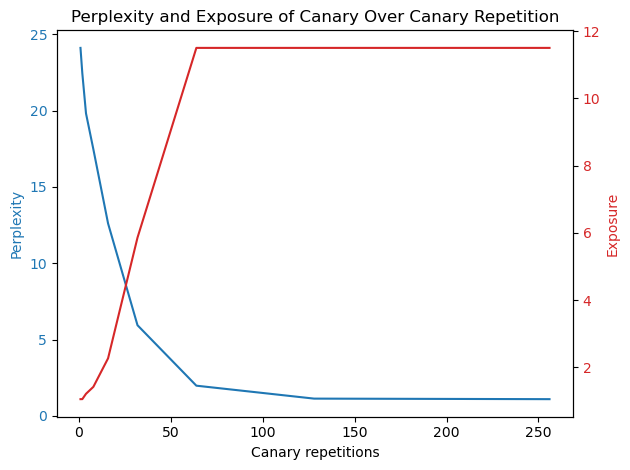

In [ ]:
import matplotlib.pyplot as plt

# Data extracted from the given text
repetition = [1, 2, 4, 8, 16, 32, 64, 128, 256]
perplexity = [24.101259231567383, 22.439464569091797, 19.811981201171875, 17.464740753173828, 12.602038383483887, 5.937135696411133, 1.9777286052703857, 1.1307135820388794, 1.0950376987457275]
exposure = [1.0527255741474661, 1.053758653347277, 1.2119758053911092, 1.418692838203059, 2.267222202797228, 5.8569856897822055, 11.50084187955693, 11.50084187955693, 11.50084187955693]

# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot perplexity on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Canary repetitions')
ax1.set_ylabel('Perplexity', color=color)
ax1.plot(repetition, perplexity, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for exposure
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Exposure', color=color)
ax2.plot(repetition, exposure, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.title('Perplexity and Exposure of Canary Over Canary Repetition')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# Extract data for plotting
canaries_list = [result['canaries_number'] for result in results]
lora_rank_list = [result['lora_rank'] for result in results]
perplexities = [result['perplexity'] for result in results]
exposures = [result['exposure'] for result in results]

# Create scatter plots
plt.figure(figsize=(12, 6))

# Perplexity scatter plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(canaries_list, lora_rank_list, c=perplexities, cmap='viridis')
plt.colorbar(scatter, label='Perplexity')
plt.xlabel('Canaries Number')
plt.ylabel('LoRA Rank')
plt.title('Perplexity vs Canaries Number and LoRA Rank')

# Exposure scatter plot
plt.subplot(1, 2, 2)
scatter = plt.scatter(canaries_list, lora_rank_list, c=exposures, cmap='plasma')
plt.colorbar(scatter, label='Exposure')
plt.xlabel('Canaries Number')
plt.ylabel('LoRA Rank')
plt.title('Exposure vs Canaries Number and LoRA Rank')

plt.tight_layout()
plt.show()